# Gradient Descent Method

In this notebook, we implement and test gradient descent methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

colours = plt.get_cmap("GnBu")
#%matplotlib widget

## The method

The Gradient descent method is a method that minimises a differentiable function $f$, by following an antigradient direction at each step:

$$\begin{aligned}
d_k &= -\nabla f(x_k)\\
x_{k+1} &= x_k + \alpha_k d_k
\end{aligned}$$

Gradient descent vary depending on how the step $\alpha_k$ is computed.

In [2]:
# Gradient descent are in fact a class of algorithms: they vary depending on the step.
class gradientDescent:
    # Initialisation function: set the line search.
    def __init__(self,ls):
        self.lineSearch = ls # Make the line search function a parameter of the class of methods.
    
    # We implement the method as a generator function: `yield` returns the value of the iterate at each iteration.
    def __call__(self,f,df,x0):
        # Initialisation:
        x = x0
        while True:
            yield(x)
            d = -df(x)                 # The next iterate will be found in the direction of the antigradient.
            a = self.lineSearch(f,d,x) # We find the step by doing a line search
            x = x + a*d                # Then obtain the next iterate.


## Line search

There are a number of line searches proposed in the literature. Some are very simple, and some are more sophisticated. 

Because many of these line searches depend on parameters, we implement them as class of methods, again.

### Constant step size
The simplest type of search is one where the step $\alpha_k$ is constant: $\alpha_k=c$. It is commonly used in deep learning.

In our implementation, we normalise the direction, that is we assume that $\|d\|=1$. Alternatively, this means that we set $\alpha_k = \tfrac{c}{\|d\|}$.

In [3]:
# Let us define a few line searches:

class constantSearch:
    """
    Return a constant step size in the normalised direction d.
    """
    def __init__(self,c):
        self.c = c       # The value of the constant.
        
    def name(self):
        """
        return the name of the line search, as well as the parameter."
        """
        # This is useful when we will compare the algorithm with different line searches.
        return "Constant search, c={}".format(self.c)
        
    def __call__(self,f,d,x):
        return self.c/norm(d) # As promised: return a constant, and we normalise over d.

### Optimal Step size

At the other extreme of step sizes is the optimal step size: we minimise the function of one variable along the direction $d$: 
$$
\alpha_k = \mathop{\mathrm{argmin}}_{t>0} f(x_k + td_k)
$$

This is mighty hard! Here we cheat a little bit: we only find a local minimiser, by going downhill using smaller and smaller steps.

In [5]:
class optimalSearch:
    """
    Perform a (locally) optimal line search in the direction d.
    """
    def __init__(self,e):
        self.e = e # Tolerance
        
    def name(self):
        return "Optimal Search"
    
    def __call__(self,f,d,x):
        # The way we perform the line search is not very efficient, but it's enough for demonstration purpose.
        # We follow the direction d using steps of size t, until we start going up. When that happens, we reduce the step size and 
        # go the other way.
        s = 1 # initial step size
        a = 0 # This will contain the step size. It will be updated every time we make a valid move in the direction.
        c = -0.5 # Step size multiplier, to update the step size once we've reached an uphill step.
        while np.abs(s)>self.e:
            while f(x+a*d) > f(x + (a+s)*d):
                a = a+s
            a = a+s
            s *= c
        return a

### Diminishing Steps

A simple alternative to the constant step size is to use a sequence of step sizes that follows the following condition:

$$\lim_{k\to \infty} \alpha_k= 0\quad \sum_{i=0}^{\infty} \alpha_k = \infty$$

This ensures that the step sizes decrease, as doing big steps is not wise when we are close to the minimiser. It also ensures that the step sizes don't decrease too quickly.

In our implementation, we use the very simple sequence $\alpha_k = \tfrac{1}{k}$. You can play around with this.

In [6]:
class diminishingSteps:
    """
    Perform a step following the diminishing step rule:
    $\lim_{k\to \infty} a_k = 0$ and $$\sum_{i=0}^n a_k = \infty$$
    """
    def __init__(self):
        self.k = 0
        self.c = 0
    
    def name(self):
        return "Diminishing Steps"
    
    def __call__(self,f,d,x):

        if self.k == 0:
            self.c = 1/norm(d)
        self.k += 1
        return self.c/(self.k)
    

### Backtracking Line Search

The backtracking line search is a compromise between the unsophisticated constant and diminishing steps, and the oversophisticated optimal line search. We try to perform the largest step that satisfies a condition - generally Armijo's. 



In [7]:
    class backtracking:
        """
        Perform a backtracking line search, until we reach a step size satisfying Armijo's condition.
        """
        def __init__(self,c,g):
            self.c = c # The constant in Armijo's condition.
            self.g = g # The multiplier for the step size.

        def name(self):
            return "Backtracking search, c={}, $\gamma={}$".format(self.c,self.g)

        def __call__(self,f,d,x):
            a = 1   # Initialise step size.
            # Approximate the directional derivative of f at x:
            h = 1e-6/norm(d)
            df = (f(x+h*d) - f(x))/h
            ndf = norm(df)      
            while f(x) - f(x+a*d) < self.c*a*ndf:
                a *= self.g
            return a

## Experiments.

### Convex, quadratic function:

We minimise:
$$ f(x) = \frac{1}{10}x_1^2 + x_2^2 $$

In [8]:
def f2(x,y):
    return 0.1*x**2 + y**2

def f(x):
    return f2(x[0],x[1])

def df(x):
    return np.array([2*0.1*x[0],2*x[1]])

Text(0.5, 1.0, 'Steepest gradient method using various line searches')

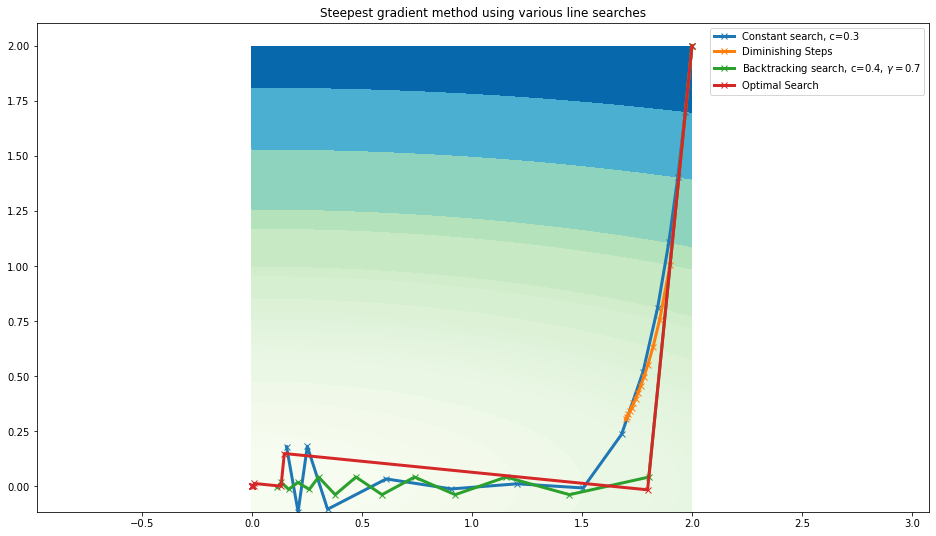

In [11]:
## Running some test algorithms, and plotting.


# Prepare the plot
fig, ax = plt.subplots(figsize=(16,9))
contours = []

# Initial point
x0 = np.array([2,2])

xmin = xmax = x0[0]
ymin = ymax = x0[1]

# line search methods that we want to try:
searchMethods = [constantSearch(0.3),diminishingSteps(),backtracking(0.4,0.7),optimalSearch(1e-6)]
for ls in searchMethods:
    # Initialise the method:
    method = gradientDescent(ls)(f,df,x0)
    
    # Then run the method for 10 iterations, and record the iterates:
    niter = 15
    xk = np.array([next(method) for _ in range(niter)]).T
    
    # Plot our iteration path:
    ax.plot(xk[0],xk[1],marker='x',linewidth=3,label=ls.name())   
    
    # Record some data (for the contour plot):
    xmin = min(xk[0].min(),xmin)
    xmax = max(xk[0].max(),xmax)
    ymin = min(xk[1].min(),ymin)
    ymax = max(xk[1].max(),ymax)
    contours.extend(f(xk))
    
# Draw the contours:

# First we generate a grid, for the contour plots if the objective function.
delta = 0.001
x = np.arange(xmin, xmax, delta)
y = np.arange(ymin, ymax, delta)
X, Y = np.meshgrid(x, y)
Z = f2(X,Y)

# Then we draw the contour
contours = np.unique(np.sort(contours))
CS = ax.contourf(X, Y, Z,contours,cmap=colours)#, colors='k') 
ax.legend()
ax.axis('equal')
#ax.set_aspect('equal', 'box')
ax.set_title('Steepest gradient method using various line searches')

In [ ]:
display(fig)

In [12]:
plt.close('all')

### Nonconvex function

We now consider the Rosenbrock function

$$ f(x) = (a-x)^2 + b(y-x^2)^2$$.

The gradient is:
$$
\nabla f(x) = \begin{bmatrix}
-2(a-x)-4bx(y-x^2)\\
2b(y-x^2)
\end{bmatrix}
$$

Here we will take $a=1$ and $b=100$.

In [13]:
a,b = (1,100)

def f2(x,y):
    return (a-x)**2 + b*(y-x**2)**2

def f(x):
    return f2(x[0],x[1])

def df(x):
    return np.array([-2*(a-x[0])-4*b*x[0]*(x[1]-x[0]**2),2*b*(x[1]-x[0]**2)])

Text(0.5, 1.0, 'Steepest gradient method using various line searches')

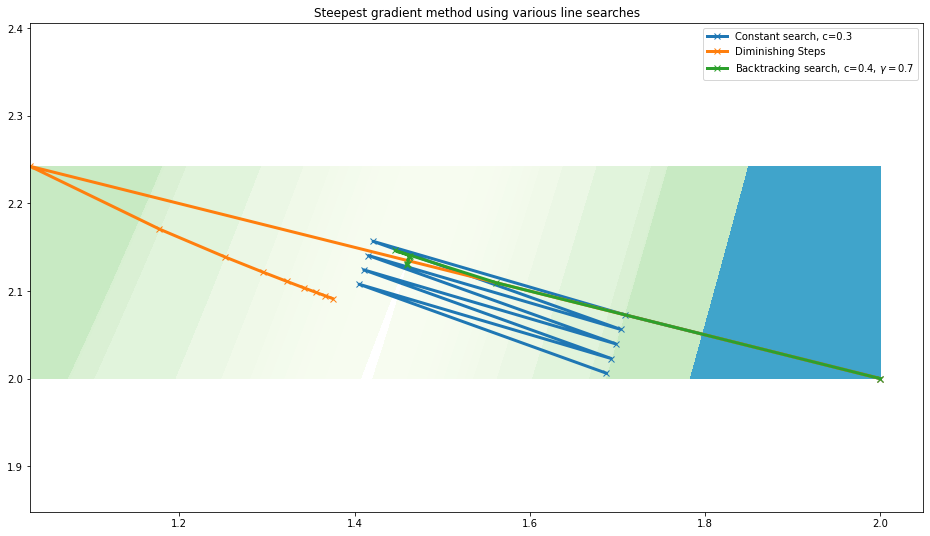

In [15]:
## Running some test algorithms, and plotting.


# Prepare the plot
fig, ax = plt.subplots(figsize=(16,9))
contours = []

# Initial point
x0 = np.array([2,2])

xmin = xmax = x0[0]
ymin = ymax = x0[1]

# line search methods that we want to try:
searchMethods = [constantSearch(0.3),diminishingSteps(),backtracking(0.4,0.7)]#,optimalSearch(1e-6)]
for ls in searchMethods:
    # Initialise the method:
    method = gradientDescent(ls)(f,df,x0)
    
    # Then run the method for 10 iterations, and record the iterates:
    niter = 10
    xk = np.array([next(method) for _ in range(niter)]).T
    
    # Plot our iteration path:
    ax.plot(xk[0],xk[1],marker='x',linewidth=3,label=ls.name())   
    
    # Record some data (for the contour plot):
    xmin = min(xk[0].min(),xmin)
    xmax = max(xk[0].max(),xmax)
    ymin = min(xk[1].min(),ymin)
    ymax = max(xk[1].max(),ymax)
    contours.extend(f(xk))
    
# Draw the contours:

# First we generate a grid, for the contour plots if the objective function.
delta = 0.001
x = np.arange(xmin, xmax, delta)
y = np.arange(ymin, ymax, delta)
X, Y = np.meshgrid(x, y)
Z = f2(X,Y)

# Then we draw the contour
contours = np.unique(np.sort(contours))
CS = ax.contourf(X, Y, Z,contours,cmap=colours)#, colors='k') 
ax.legend()
#ax.set_aspect('equal', 'box')
ax.axis('equal')
ax.set_title('Steepest gradient method using various line searches')

In [ ]:
display(fig)

# Constrained Methods

We implement algorithms for solving constrained optimisation problems.

### The Conditional Gradient Method.

The conditional gradient method is helpful when the constraints are not too complicated. Let us show what happens when they are linear inequalities of the form $Ax\leq b$.

In [16]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [17]:
# Gradient descent are in fact a class of algorithms: they vary depending on the step.
class conditionalGradient:
    # Initialisation function: set the line search.
    def __init__(self,ls):
        self.lineSearch = ls # Make the line search function a parameter of the class of methods.
        
    # We implement the method as a generator function: `yield` returns the value of the iterate at each iteration.
    def __call__(self,f,df,A,b,x0):
        # Initialisation:
        x = x0
        while True:
            yield(x)
            c = matrix(df(x))                       # The next iterate will be found in the direction of the antigradient.
            sol = solvers.lp(c,A,b-A*matrix(x))     # This will give us a feasible descent direction.
            d = np.array(sol['x']).T
            a = self.lineSearch(f,d[0],x)            # We find the step by doing a line search
            x = x + a*d[0]                           # Then obtain the next iterate.

We use the very simple constraint: $2\leq x_i\leq 3$ for every $i$.

In [18]:
# We use the very simple constraint: xi<=0 for every i
A = matrix([ [-1.0, 0.0,1.0,0.0], [0.0, -1.0,0.0,1.0] ]) 
br = matrix([-2.0,-2.0,5.0,5.0])
b = 5

Text(0.5, 1.0, 'Steepest gradient method using various line searches')

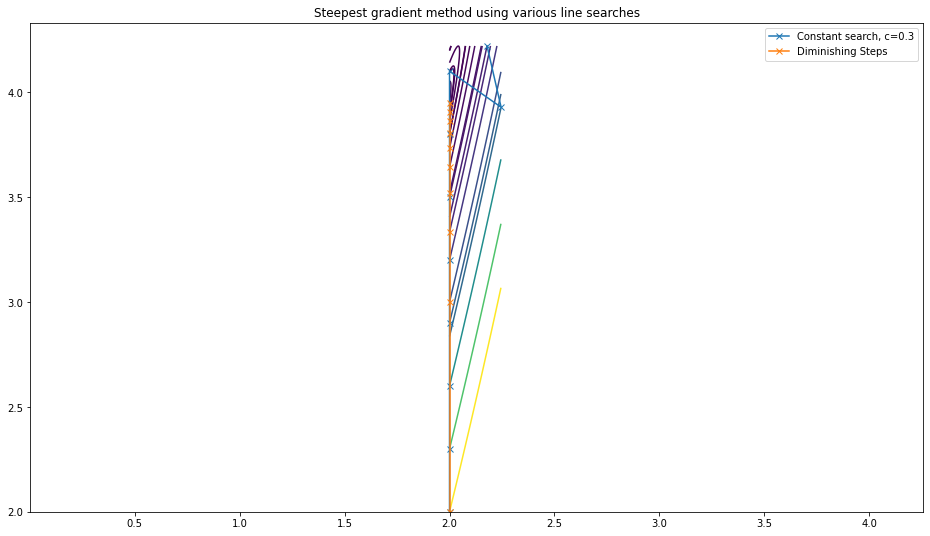

In [21]:
## Running some test algorithms, and plotting.


# Prepare the plot
fig, ax = plt.subplots(figsize=(16,9))
contours = []

# Initial point
x0 = np.array([2.0,2])

xmin = xmax = x0[0]
ymin = ymax = x0[1]

# line search methods that we want to try:
searchMethods = [constantSearch(0.3),diminishingSteps()]#,backtracking(0.4,0.7)]#,optimalSearch(1e-6)]
for ls in searchMethods:
    # Initialise the method:
    method = conditionalGradient(ls)(f,df,A,br,x0)
    
    # Then run the method for 10 iterations, and record the iterates:
    niter = 10
    xk = np.array([next(method) for _ in range(niter)]).T
    
    # Plot our iteration path:
    ax.plot(xk[0],xk[1],marker='x',label=ls.name())   
    
    # Record some data (for the contour plot):
    xmin = min(xk[0].min(),xmin)
    xmax = max(xk[0].max(),xmax)
    ymin = min(xk[1].min(),ymin)
    ymax = max(xk[1].max(),ymax)
    contours.extend(f(xk))
    
# Draw the contours:

# First we generate a grid, for the contour plots if the objective function.
delta = 0.001
x = np.arange(xmin, xmax, delta)
y = np.arange(ymin, ymax, delta)
X, Y = np.meshgrid(x, y)
Z = f2(X,Y)

# Then we draw the contour
contours = np.unique(np.sort(contours))
CS = ax.contour(X, Y, Z,contours)#, colors='k') 
ax.legend()
#ax.set_aspect('equal', 'box')
ax.axis('equal')
ax.set_title('Steepest gradient method using various line searches')

In [ ]:
display(fig)